In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from matplotlib import pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [2]:
def get_file_names(folder):
    #Listing entries present in given folder
    entries = os.listdir(folder)
    for i in entries:
        if 'csv' not in i:
            entries.remove(i)
    return sorted(entries, reverse=True)[0:12]

train_path = "../split_datasets/train/"
test_path = "../split_datasets/test/"
val_path = "../split_datasets/validation/"

train_files = get_file_names(train_path)
test_files = get_file_names(test_path)
val_files = get_file_names(val_path)

frames = []
for i in train_files:
    frames.append(pd.read_csv(train_path+i)[0:1000])
    break
train_df = pd.concat(frames, sort=False)
train_df = train_df.drop(columns="id")
train_df = train_df.drop(columns="last_scraped")
train_df = train_df.fillna(0)

frames = []
for i in test_files:
    frames.append(pd.read_csv(test_path+i))
    break
test_df = pd.concat(frames, sort=False)
test_df = test_df.drop(columns="id")
test_df = test_df.drop(columns="last_scraped")
test_df = test_df.fillna(0)

frames = []
for i in val_files:
    frames.append(pd.read_csv(val_path+i))
    break
val_df = pd.concat(frames, sort=False)
val_df = val_df.drop(columns="id")
val_df = val_df.drop(columns="last_scraped")
val_df = val_df.fillna(0)

minimum = min(train_df['price'].min(), test_df['price'].min(), val_df['price'].min())
maximum = max(train_df['price'].max(), test_df['price'].max(), val_df['price'].max())

train_df['price'] = (train_df['price'] - minimum)/(maximum - minimum)
train_df = train_df.reset_index(drop=True)
test_df['price'] = (test_df['price'] - minimum)/(maximum - minimum)
test_df = test_df.reset_index(drop=True)
val_df['price'] = (val_df['price'] - minimum)/(maximum - minimum)
val_df = val_df.reset_index(drop=True)
train_df = train_df.drop(columns=["minimum_nights", "maximum_nights"])
test_df = test_df.drop(columns=["minimum_nights", "maximum_nights"])
val_df = val_df.drop(columns=["minimum_nights", "maximum_nights"])

print(minimum, maximum)

36 349


In [3]:
train_df.head(5)

,accommodates,bathrooms,bedrooms,beds,price,amenities_TV,amenities_Internet,amenities_Wifi,amenities_Air conditioning,amenities_Kitchen,...,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,instant_bookable_f,instant_bookable_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
0,4,1.0,2.0,2.0,0.214058,1,1,1,1,1,...,1,0,0,1,0,0,0,1,0,0
1,6,2.0,3.0,3.0,0.325879,1,0,1,1,1,...,1,0,0,0,1,0,0,1,0,0
2,4,2.5,1.0,1.0,0.140575,1,0,1,1,1,...,0,1,0,1,0,1,0,0,0,0
3,2,1.0,1.0,2.0,0.031949,1,0,1,1,1,...,0,1,0,1,0,0,1,0,0,0
4,2,1.5,1.0,1.0,0.236422,1,0,1,1,1,...,0,1,0,1,0,1,0,0,0,0


In [4]:
class airbnb_dataset (Dataset):
    def __init__(self, df, purpose):
        self.df = df
        self.price = self.df["price"]
        self.df = self.df.drop(columns="price")
        self.purpose = purpose
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        # Returns specific sample as a dict
        if torch.is_tensor(index):
            index = index.tolist()
        sample = torch.tensor(self.df.iloc[index]).float()
        label = torch.tensor([self.price.iloc[index]]).float()
        return {"sample": sample, "label": label}

In [5]:
train_ds = airbnb_dataset(train_df, "train")
test_ds = airbnb_dataset(test_df, "test")
val_ds = airbnb_dataset(val_df, "test")

train_loader = DataLoader(train_ds, batch_size=1000, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1000, shuffle=False, num_workers=0)

In [6]:
class airbnb_net (nn.Module):
    def __init__(self):
        super(airbnb_net, self).__init__()
        self.layer1 = nn.Linear(256, 528)
        self.layer2 = nn.Linear(528, 528)
        self.layer3 = nn.Linear(528, 250)
        self.layer4 = nn.Linear(250, 1)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        return self.layer4(x)

In [7]:
def train(net, train_loader, val_loader, bounds):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum = 0.9)
    
    print("Starting Training...")
    start_time = time.time()
    epochs, losses = [], []
    
    for epoch in range(200):
        epoch_loss = 0
        epoch_time = time.time()
        batch_loss = 0
        batch_time = time.time()
        for i, data in enumerate(train_loader):
            sample = data["sample"]
            label = data["label"]
            output = net(sample)
            loss = criterion(output, label)
            #print(label, output)
            #print(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            batch_loss += loss.item()
            epoch_loss += loss.item()
            if i % 10 == 9:
                batch_loss = batch_loss/10
                print("---[ITER %d] loss: %.6f  time: %.3f" % (i+1, batch_loss, time.time()-batch_time))
                batch_loss = 0
                batch_time = time.time()
        epoch_loss /= len(train_loader)
        
        epochs.append(epoch)
        losses.append(epoch_loss)
        
        print("[EPOCH %d] loss: %.6f  time: %.3f" % (epoch+1, epoch_loss, time.time()-epoch_time))
        
        if epoch % 5 == 4:
            plt.title("Training Curve")
            plt.plot(losses, label="Train")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.show()
        
    print("=========================================")
    print("Training Completed...")
    print("[FINAL] loss: %.6f  time: %.3f" % (epoch_loss, time.time()-start_time))
          
        
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    
'''
    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
'''            

'\n    plt.title("Training Curve")\n    plt.plot(epochs, train_acc, label="Train")\n    plt.plot(epochs, valid_acc, label="Validation")\n    plt.xlabel("Epoch")\n    plt.ylabel("Accuracy")\n    plt.legend(loc=\'best\')\n    plt.show()\n'

In [8]:
def get_error(model, train_loader, val_loader, threshold, bounds):
    train_samples = 0
    train_error = 0
    train_accuracy = 0
    for i, data in enumerate(train_loader):
        sample = data["sample"]
        label = data["label"]
        output = net(sample)
        error = abs(label-output)
        accurate = (error < float(threshold)/float(bounds[1]-bounds[0]))
        train_samples += len(label)
        train_error += error.sum().item()
        train_accuracy += accurate.sum().item()
    avg_train_error = float(train_error)/float(train_samples)*(bounds[1]-bounds[0])
    avg_train_accuracy = float(train_accuracy)/float(train_samples)
    
    val_samples = 0
    val_error = 0
    val_accuracy = 0
    for i, data in enumerate(val_loader):
        sample = data["sample"]
        label = data["label"]
        output = net(sample)
        error = abs(label-output)
        accurate = (error < float(threshold)/float(bounds[1]-bounds[0]))
        val_samples += len(label)
        val_error += error.sum().item()
        val_accuracy += accurate.sum().item()
    avg_val_error = float(val_error)/float(val_samples)*(bounds[1]-bounds[0])
    avg_val_accuracy = float(val_accuracy)/float(val_samples)
    return avg_train_error, avg_train_accuracy, avg_val_error, avg_val_accuracy

In [9]:
net = airbnb_net()

Starting Training...
[EPOCH 1] loss: 0.043004  time: 2.902
[EPOCH 2] loss: 0.041915  time: 2.468
[EPOCH 3] loss: 0.039937  time: 2.474
[EPOCH 4] loss: 0.037309  time: 2.470
[EPOCH 5] loss: 0.034288  time: 2.589


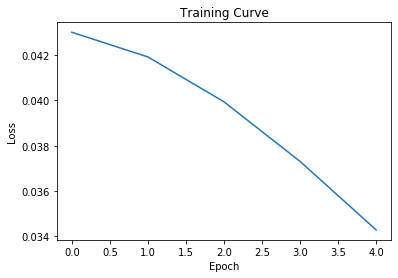

[EPOCH 6] loss: 0.031120  time: 2.632
[EPOCH 7] loss: 0.028026  time: 3.007
[EPOCH 8] loss: 0.025182  time: 3.293
[EPOCH 9] loss: 0.022720  time: 3.472
[EPOCH 10] loss: 0.020719  time: 3.275


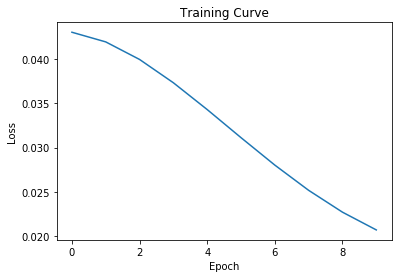

[EPOCH 11] loss: 0.019213  time: 3.075
[EPOCH 12] loss: 0.018193  time: 2.818
[EPOCH 13] loss: 0.017615  time: 4.372
[EPOCH 14] loss: 0.017413  time: 2.661
[EPOCH 15] loss: 0.017503  time: 2.624


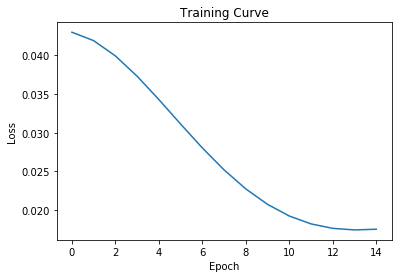

[EPOCH 16] loss: 0.017791  time: 2.601
[EPOCH 17] loss: 0.018184  time: 2.650
[EPOCH 18] loss: 0.018602  time: 3.002
[EPOCH 19] loss: 0.018974  time: 2.971
[EPOCH 20] loss: 0.019252  time: 3.028


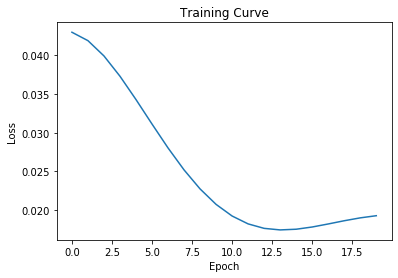

[EPOCH 21] loss: 0.019406  time: 2.830
[EPOCH 22] loss: 0.019424  time: 2.700
[EPOCH 23] loss: 0.019313  time: 2.891
[EPOCH 24] loss: 0.019092  time: 2.847
[EPOCH 25] loss: 0.018788  time: 2.653


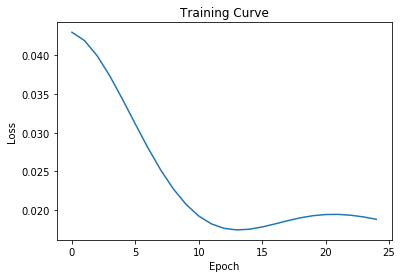

[EPOCH 26] loss: 0.018432  time: 3.089
[EPOCH 27] loss: 0.018055  time: 2.547
[EPOCH 28] loss: 0.017684  time: 2.666
[EPOCH 29] loss: 0.017340  time: 2.638
[EPOCH 30] loss: 0.017040  time: 3.010


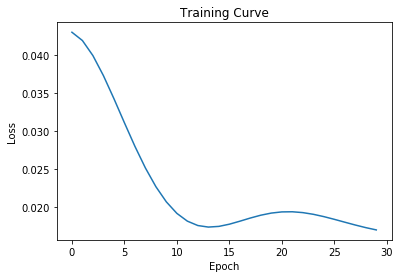

[EPOCH 31] loss: 0.016792  time: 2.785
[EPOCH 32] loss: 0.016598  time: 2.705
[EPOCH 33] loss: 0.016455  time: 3.105
[EPOCH 34] loss: 0.016359  time: 2.563
[EPOCH 35] loss: 0.016300  time: 2.459


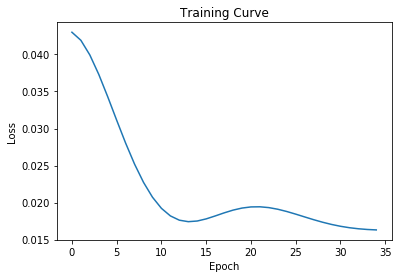

[EPOCH 36] loss: 0.016268  time: 2.439
[EPOCH 37] loss: 0.016254  time: 2.751
[EPOCH 38] loss: 0.016248  time: 2.693
[EPOCH 39] loss: 0.016243  time: 2.709
[EPOCH 40] loss: 0.016232  time: 2.511


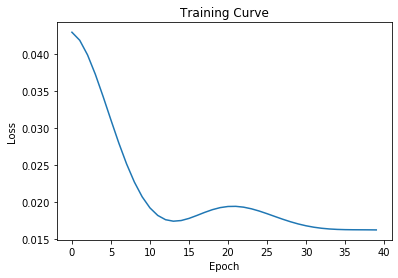

[EPOCH 41] loss: 0.016211  time: 2.515
[EPOCH 42] loss: 0.016177  time: 2.519
[EPOCH 43] loss: 0.016130  time: 2.555
[EPOCH 44] loss: 0.016070  time: 2.547
[EPOCH 45] loss: 0.015999  time: 2.527


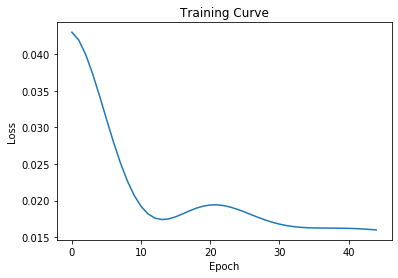

[EPOCH 46] loss: 0.015919  time: 2.612
[EPOCH 47] loss: 0.015833  time: 3.162
[EPOCH 48] loss: 0.015745  time: 2.883
[EPOCH 49] loss: 0.015657  time: 2.510
[EPOCH 50] loss: 0.015571  time: 2.471


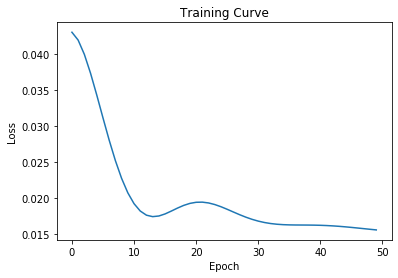

[EPOCH 51] loss: 0.015489  time: 2.486
[EPOCH 52] loss: 0.015413  time: 2.475
[EPOCH 53] loss: 0.015343  time: 2.608
[EPOCH 54] loss: 0.015280  time: 2.789
[EPOCH 55] loss: 0.015222  time: 3.021


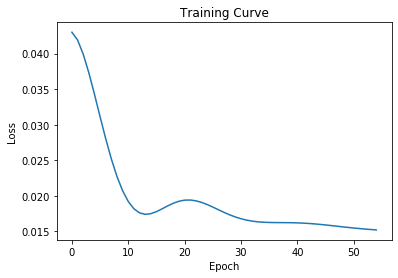

[EPOCH 56] loss: 0.015169  time: 2.842
[EPOCH 57] loss: 0.015120  time: 2.499
[EPOCH 58] loss: 0.015074  time: 2.743
[EPOCH 59] loss: 0.015029  time: 2.474
[EPOCH 60] loss: 0.014985  time: 2.473


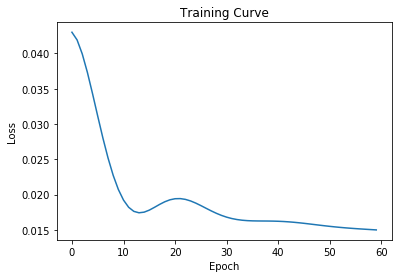

[EPOCH 61] loss: 0.014940  time: 2.685
[EPOCH 62] loss: 0.014895  time: 2.524
[EPOCH 63] loss: 0.014848  time: 2.503
[EPOCH 64] loss: 0.014799  time: 2.734
[EPOCH 65] loss: 0.014749  time: 2.625


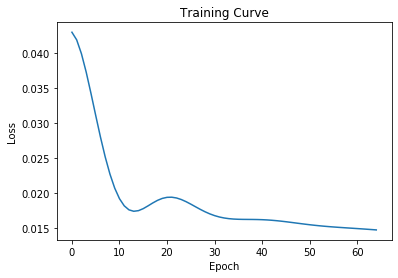

[EPOCH 66] loss: 0.014697  time: 2.512
[EPOCH 67] loss: 0.014645  time: 2.795
[EPOCH 68] loss: 0.014593  time: 2.554
[EPOCH 69] loss: 0.014541  time: 2.466
[EPOCH 70] loss: 0.014489  time: 2.470


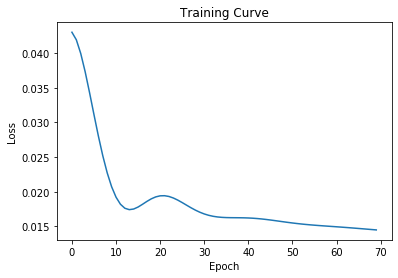

[EPOCH 71] loss: 0.014438  time: 2.448
[EPOCH 72] loss: 0.014388  time: 2.635
[EPOCH 73] loss: 0.014339  time: 2.874
[EPOCH 74] loss: 0.014292  time: 2.469
[EPOCH 75] loss: 0.014245  time: 2.503


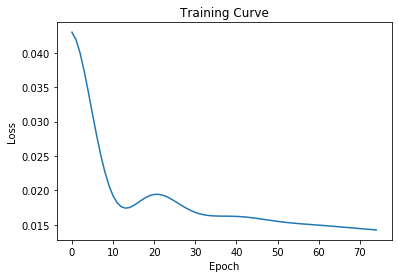

[EPOCH 76] loss: 0.014200  time: 2.453
[EPOCH 77] loss: 0.014155  time: 2.770
[EPOCH 78] loss: 0.014111  time: 2.473
[EPOCH 79] loss: 0.014068  time: 2.558
[EPOCH 80] loss: 0.014025  time: 2.505


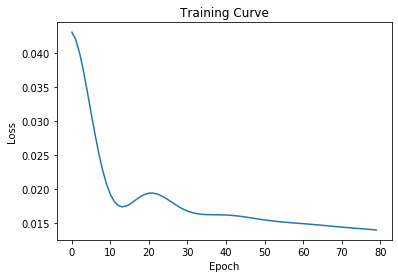

[EPOCH 81] loss: 0.013982  time: 2.470
[EPOCH 82] loss: 0.013940  time: 2.817
[EPOCH 83] loss: 0.013897  time: 2.659
[EPOCH 84] loss: 0.013855  time: 2.527
[EPOCH 85] loss: 0.013813  time: 2.762


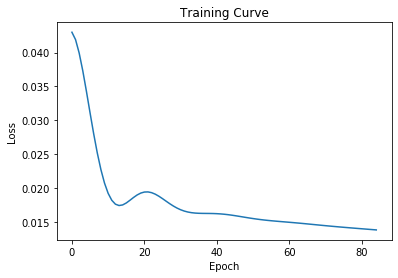

[EPOCH 86] loss: 0.013771  time: 3.048
[EPOCH 87] loss: 0.013730  time: 3.504
[EPOCH 88] loss: 0.013689  time: 2.609
[EPOCH 89] loss: 0.013648  time: 2.494
[EPOCH 90] loss: 0.013608  time: 2.519


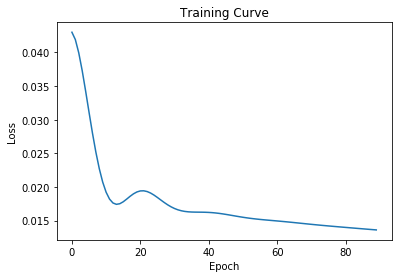

[EPOCH 91] loss: 0.013568  time: 2.505
[EPOCH 92] loss: 0.013529  time: 2.749
[EPOCH 93] loss: 0.013490  time: 2.504
[EPOCH 94] loss: 0.013452  time: 2.504
[EPOCH 95] loss: 0.013414  time: 2.555


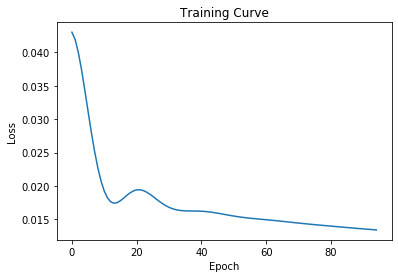

[EPOCH 96] loss: 0.013377  time: 2.738
[EPOCH 97] loss: 0.013340  time: 2.713
[EPOCH 98] loss: 0.013303  time: 2.910
[EPOCH 99] loss: 0.013267  time: 2.557
[EPOCH 100] loss: 0.013231  time: 2.713


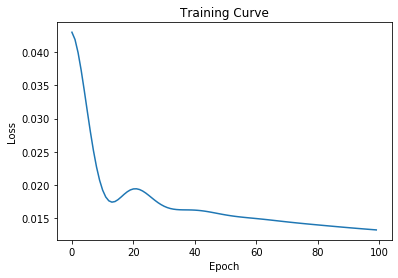

[EPOCH 101] loss: 0.013195  time: 3.242
[EPOCH 102] loss: 0.013160  time: 3.172
[EPOCH 103] loss: 0.013125  time: 2.913
[EPOCH 104] loss: 0.013090  time: 2.561
[EPOCH 105] loss: 0.013055  time: 2.754


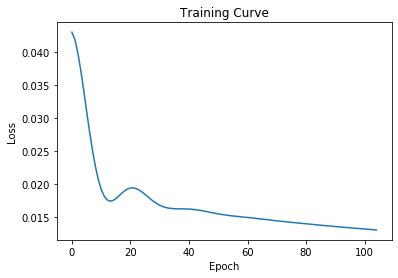

[EPOCH 106] loss: 0.013021  time: 2.446
[EPOCH 107] loss: 0.012987  time: 2.474
[EPOCH 108] loss: 0.012954  time: 2.475
[EPOCH 109] loss: 0.012921  time: 2.464
[EPOCH 110] loss: 0.012888  time: 2.466


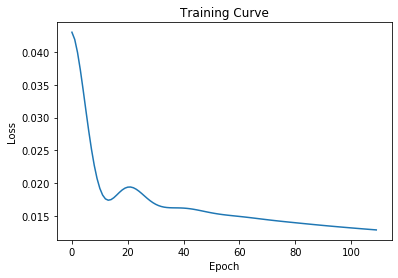

[EPOCH 111] loss: 0.012856  time: 2.446
[EPOCH 112] loss: 0.012823  time: 2.510
[EPOCH 113] loss: 0.012792  time: 2.485
[EPOCH 114] loss: 0.012760  time: 2.474
[EPOCH 115] loss: 0.012729  time: 2.480


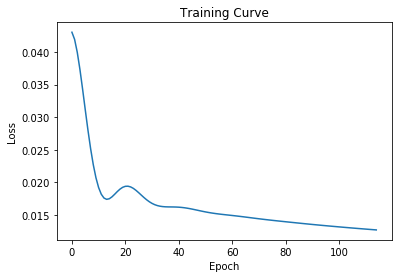

[EPOCH 116] loss: 0.012698  time: 2.463
[EPOCH 117] loss: 0.012668  time: 2.773
[EPOCH 118] loss: 0.012637  time: 2.986
[EPOCH 119] loss: 0.012607  time: 2.480
[EPOCH 120] loss: 0.012578  time: 2.995


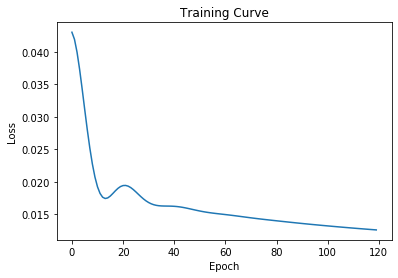

[EPOCH 121] loss: 0.012549  time: 2.922
[EPOCH 122] loss: 0.012519  time: 2.978
[EPOCH 123] loss: 0.012491  time: 9.303
[EPOCH 124] loss: 0.012462  time: 5.143
[EPOCH 125] loss: 0.012434  time: 4.273


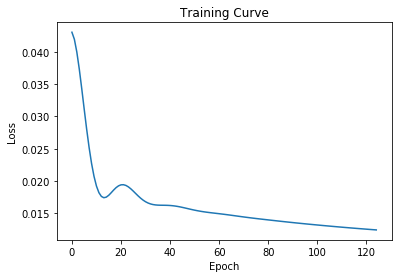

[EPOCH 126] loss: 0.012406  time: 2.523
[EPOCH 127] loss: 0.012379  time: 2.488
[EPOCH 128] loss: 0.012352  time: 2.474
[EPOCH 129] loss: 0.012325  time: 2.554
[EPOCH 130] loss: 0.012298  time: 2.473


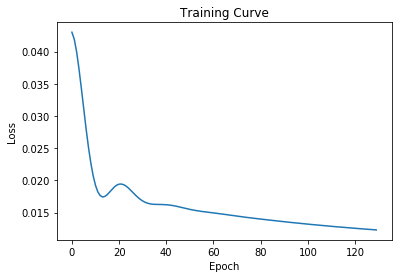

[EPOCH 131] loss: 0.012272  time: 2.448
[EPOCH 132] loss: 0.012245  time: 2.521
[EPOCH 133] loss: 0.012220  time: 2.480
[EPOCH 134] loss: 0.012194  time: 2.458
[EPOCH 135] loss: 0.012169  time: 2.455


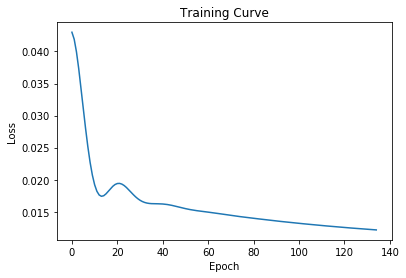

[EPOCH 136] loss: 0.012144  time: 2.436
[EPOCH 137] loss: 0.012119  time: 2.444
[EPOCH 138] loss: 0.012094  time: 2.444
[EPOCH 139] loss: 0.012070  time: 2.617
[EPOCH 140] loss: 0.012046  time: 2.508


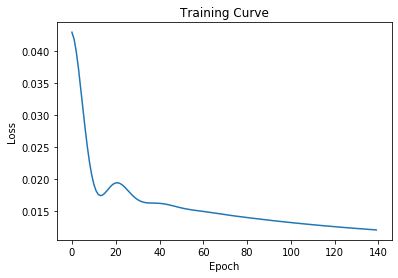

[EPOCH 141] loss: 0.012022  time: 2.792
[EPOCH 142] loss: 0.011998  time: 2.997
[EPOCH 143] loss: 0.011975  time: 2.568
[EPOCH 144] loss: 0.011951  time: 3.361
[EPOCH 145] loss: 0.011928  time: 2.518


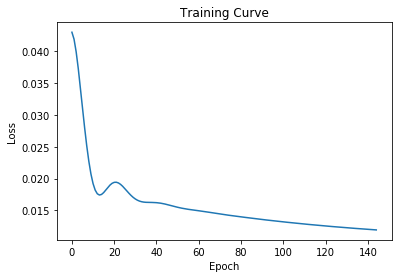

[EPOCH 146] loss: 0.011906  time: 2.451
[EPOCH 147] loss: 0.011883  time: 2.487
[EPOCH 148] loss: 0.011861  time: 2.477
[EPOCH 149] loss: 0.011839  time: 2.456
[EPOCH 150] loss: 0.011817  time: 2.482


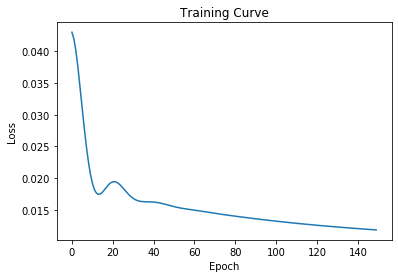

[EPOCH 151] loss: 0.011795  time: 2.429
[EPOCH 152] loss: 0.011773  time: 2.467
[EPOCH 153] loss: 0.011752  time: 2.460
[EPOCH 154] loss: 0.011731  time: 2.462
[EPOCH 155] loss: 0.011710  time: 2.889


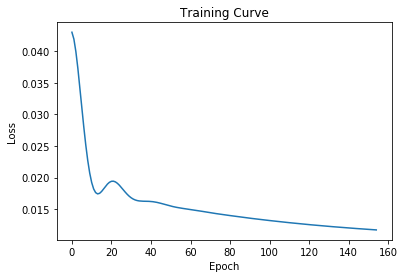

[EPOCH 156] loss: 0.011689  time: 2.908
[EPOCH 157] loss: 0.011669  time: 2.733
[EPOCH 158] loss: 0.011649  time: 2.517
[EPOCH 159] loss: 0.011629  time: 2.467
[EPOCH 160] loss: 0.011609  time: 2.470


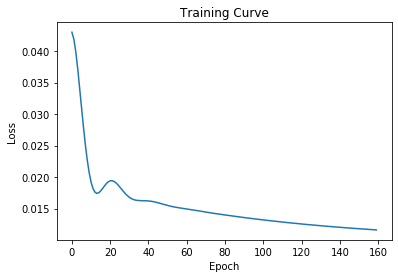

[EPOCH 161] loss: 0.011589  time: 2.519
[EPOCH 162] loss: 0.011569  time: 2.468
[EPOCH 163] loss: 0.011550  time: 2.531
[EPOCH 164] loss: 0.011531  time: 2.959
[EPOCH 165] loss: 0.011512  time: 3.089


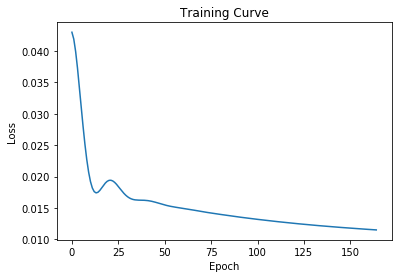

[EPOCH 166] loss: 0.011493  time: 6.635
[EPOCH 167] loss: 0.011474  time: 2.988
[EPOCH 168] loss: 0.011455  time: 3.679
[EPOCH 169] loss: 0.011437  time: 2.830
[EPOCH 170] loss: 0.011419  time: 2.489


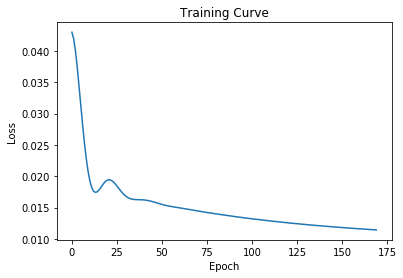

[EPOCH 171] loss: 0.011401  time: 2.502
[EPOCH 172] loss: 0.011383  time: 2.465
[EPOCH 173] loss: 0.011365  time: 2.464
[EPOCH 174] loss: 0.011347  time: 2.487
[EPOCH 175] loss: 0.011330  time: 2.538


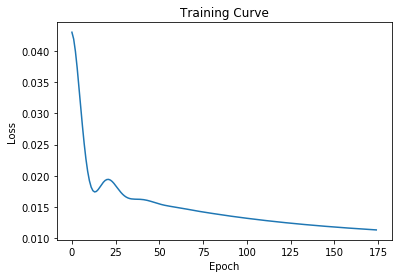

[EPOCH 176] loss: 0.011313  time: 3.212
[EPOCH 177] loss: 0.011295  time: 3.069
[EPOCH 178] loss: 0.011278  time: 3.485
[EPOCH 179] loss: 0.011262  time: 5.315
[EPOCH 180] loss: 0.011245  time: 4.064


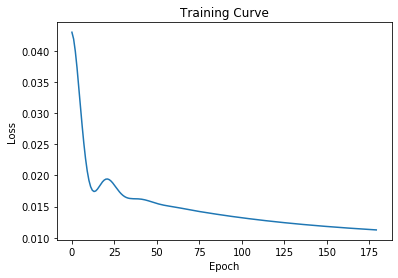

[EPOCH 181] loss: 0.011228  time: 3.348
[EPOCH 182] loss: 0.011212  time: 3.099
[EPOCH 183] loss: 0.011196  time: 2.975
[EPOCH 184] loss: 0.011179  time: 2.599
[EPOCH 185] loss: 0.011163  time: 2.582


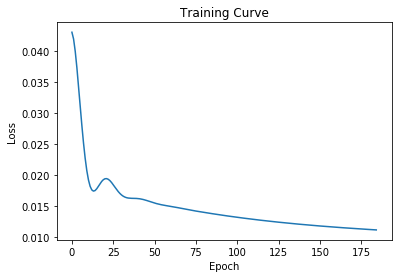

[EPOCH 186] loss: 0.011147  time: 3.855
[EPOCH 187] loss: 0.011131  time: 2.627
[EPOCH 188] loss: 0.011116  time: 2.516
[EPOCH 189] loss: 0.011100  time: 2.517
[EPOCH 190] loss: 0.011085  time: 2.492


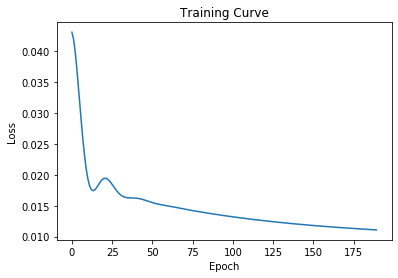

[EPOCH 191] loss: 0.011069  time: 2.509
[EPOCH 192] loss: 0.011054  time: 2.514
[EPOCH 193] loss: 0.011039  time: 2.511
[EPOCH 194] loss: 0.011024  time: 2.526
[EPOCH 195] loss: 0.011009  time: 2.540


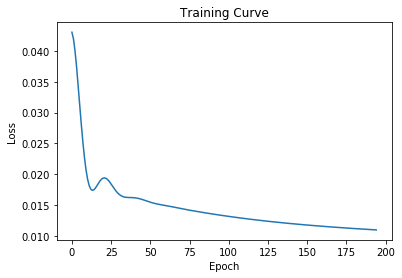

[EPOCH 196] loss: 0.010994  time: 2.570
[EPOCH 197] loss: 0.010980  time: 2.786
[EPOCH 198] loss: 0.010965  time: 2.670
[EPOCH 199] loss: 0.010951  time: 2.610
[EPOCH 200] loss: 0.010936  time: 2.643


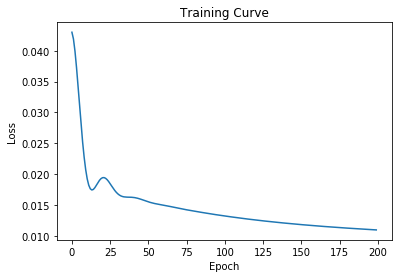

Training Completed...
[FINAL] loss: 0.010936  time: 562.561


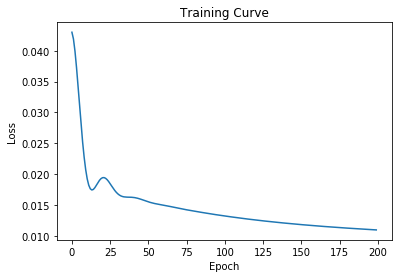

In [10]:
train(net, train_loader, val_loader, [minimum, maximum])

In [13]:
for i in range(5, 35, 5):
    print(get_error(net, train_loader, val_loader, i, [minimum, maximum]))

(35.0024061050415, 0.078, 38.479926016671314, 0.07844155844155844)
(35.0024061050415, 0.178, 38.479926016671314, 0.16623376623376623)
(35.0024061050415, 0.263, 38.479926016671314, 0.2587012987012987)
(35.0024061050415, 0.345, 38.479926016671314, 0.3425974025974026)
(35.0024061050415, 0.442, 38.479926016671314, 0.42857142857142855)
(35.0024061050415, 0.538, 38.479926016671314, 0.5109090909090909)


In [54]:
accum = 0
accum1 = 0
for i in range(100):
    error = net(train_ds[i]["sample"]).item() - train_ds[i]["label"].item()
    accum += error
    accum1 += abs(error)
    print(net(train_ds[i]["sample"]).item(), train_ds[i]["label"].item(), error)
print("Error:", accum/100)
bounds = [minimum, maximum]
print("Abs Error:", accum1/100*(bounds[1]-bounds[0]))

0.4214916527271271 0.21405750513076782 0.20743414759635925
0.5276427268981934 0.3258785903453827 0.20176413655281067
0.2150266170501709 0.1405750811100006 0.07445153594017029
0.23273341357707977 0.03194888308644295 0.20078453049063683
0.09710259735584259 0.23642171919345856 -0.13931912183761597
0.41814690828323364 0.36421725153923035 0.053929656744003296
0.31207364797592163 0.2044728398323059 0.10760080814361572
0.1313839703798294 0.2651757299900055 -0.1337917596101761
0.08688503503799438 0.01277955248951912 0.07410548254847527
0.05793289840221405 0.028753994032740593 0.029178904369473457
0.31027013063430786 0.36421725153923035 -0.053947120904922485
0.3767816424369812 0.2843450605869293 0.09243658185005188
0.2956864833831787 0.2747603952884674 0.020926088094711304
0.20870961248874664 0.2044728398323059 0.004236772656440735
0.28128132224082947 0.1405750811100006 0.14070624113082886
0.2540990710258484 0.23642171919345856 0.01767735183238983
0.12372308224439621 0.04472843557596207 0.07899

In [ ]:
for i, data in enumerate(train_loader):
    print(len(data["label"]))
    break

In [ ]:
train_ds[4]["label"].item()
